In [206]:
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn.metrics import silhouette_score ,calinski_harabasz_score,davies_bouldin_score 
import matplotlib.pyplot as plt
from pyts.approximation import PiecewiseAggregateApproximation,SymbolicAggregateApproximation
import seglearn as sgl
from seglearn.pipe import Pype
from seglearn.transform import Segment, FeatureRep, FeatureRepMix
from utils import *
from seglearn.feature_functions import *
import json
import os
import torch
import datetime as dt
from tslearn.clustering import KShape, silhouette_score
from collections import Counter
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
import pywt
from tslearn import metrics, preprocessing, piecewise
from scipy import spatial
from pyts.transformation import BagOfPatterns, ROCKET
from scipy.stats import norm
import matplotlib.lines as mlines
import random
from torch import nn
import iisignature
from pyts import datasets
from pyts.preprocessing import *
from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging, \
    dtw_barycenter_averaging_subgradient, \
    softdtw_barycenter


seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


In [2]:
train_folder = './data/train/'
# test_folder = './data/test/'
stocklist = json.load(open(train_folder+'stockNames.json'))
year=2011
folder = train_folder+str(year)+'/'
datas = {}
dates = {}
for stock in stocklist:
    file = folder+stock+'.csv'
    data = pd.read_csv(file)
    data,date = splite_data(data,-1)
    datas[stock] = data
    dates[stock] = date

# (leaf_x, _, leaf_y, _)=datasets.fetch_ucr_dataset("SwedishLeaf",return_X_y=True)

In [101]:
def pre_process_data(datas, seq_len=50, denosing=True, normalization=True, dimension=[1], compression='pip'):
    processed_data = []

    downsample = preprocessing.TimeSeriesResampler(seq_len)
    ts_paa = piecewise.PiecewiseAggregateApproximation(n_segments=seq_len)
    
    for v in datas.values():
        data = v[:,1]
        if denosing:
            data = wavelet_denoising(data)
        data = data[:,np.newaxis]
        if compression == 'pip':
            data = data[pip(data[:,0],seq_len)]
        elif compression == 'paa':
            data = ts_paa.fit_transform(data[np.newaxis,:]).squeeze()
        else:
            data = downsample.fit_transform(data[np.newaxis,:]).squeeze()
        if normalization:
            data = zero_mean_normalise(data)
        processed_data.append(data.ravel())
    processed_data = np.array(processed_data)
    return processed_data 

In [133]:
#单一变量
processed_data = pre_process_data(datas,seq_len=150)

# Bag of patterns

In [80]:
bop = BagOfPatterns(window_size=8, word_size=4, sparse=False)

In [83]:
x = bop.fit_transform(processed_data[:5])

/usr/local/lib/python3.8/site-packages/pyts/bag_of_words/bow.py:243: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  warnings.warn("BagOfWords has been reworked in 0.11 in order to match "


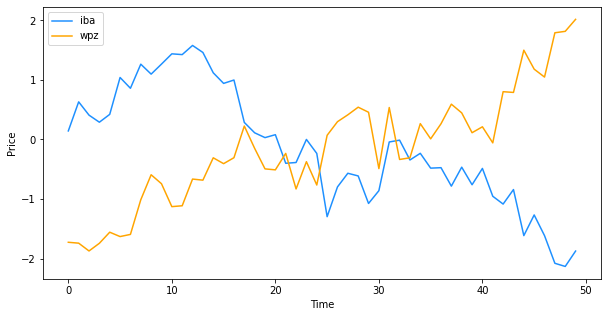

In [114]:
plt.figure(figsize=(10, 5))
plt.plot(processed_data[0], c='dodgerblue')
plt.plot(processed_data[1], c='orange')
plt.legend(company[:2])
plt.xlabel('Time')
plt.ylabel('Price')
plt.savefig('ibawpz.png',dpi=200)

/usr/local/lib/python3.8/site-packages/pyts/bag_of_words/bow.py:243: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  warnings.warn("BagOfWords has been reworked in 0.11 in order to match "


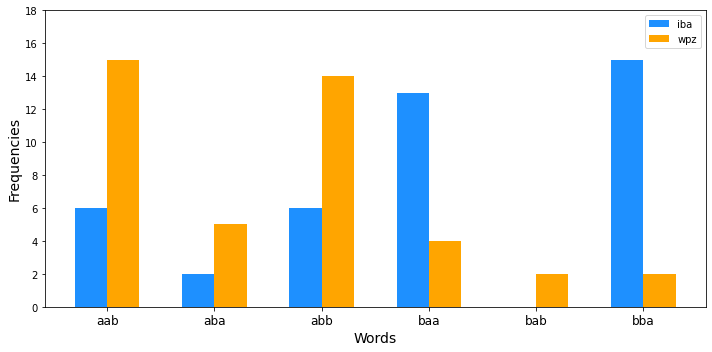

In [111]:
from pyts.datasets import load_gunpoint
from pyts.transformation import BagOfPatterns

# BOSS transformation
bop = BagOfPatterns(window_size=9, word_size=3, n_bins=2,
                    numerosity_reduction=False, sparse=False)
X_bop = bop.fit_transform(processed_data)

# Visualize the transformation for the first time series
plt.figure(figsize=(10, 5))
vocabulary_length = len(bop.vocabulary_)
width = 0.3
plt.bar(np.arange(vocabulary_length) - width / 2, X_bop[0],
        width=width, label=company[0], color='dodgerblue')
plt.bar(np.arange(vocabulary_length) + width / 2, X_bop[1],
        width=width, label=company[1], color='orange')
plt.xticks(np.arange(vocabulary_length),
           np.vectorize(bop.vocabulary_.get)(np.arange(X_bop[0].size)),
           fontsize=12)
y_max = np.max(X_bop)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequencies", fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.ylim((0, 18))
plt.tight_layout()
plt.savefig('bop1.png',dpi=200)
plt.show()

# ROCKET

In [151]:
rocket = ROCKET(n_kernels=10, random_state=42)
X_rocket = rocket.fit_transform(processed_data)

Text(0, 0.5, 'Price')

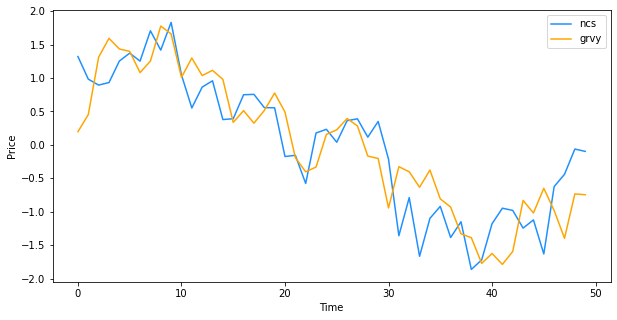

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(processed_data[3], c='dodgerblue')
plt.plot(processed_data[4], c='orange')
plt.legend(company[3:5])
plt.xlabel('Time')
plt.ylabel('Price')
# plt.savefig('ncsgrvy1.png',dpi=200)

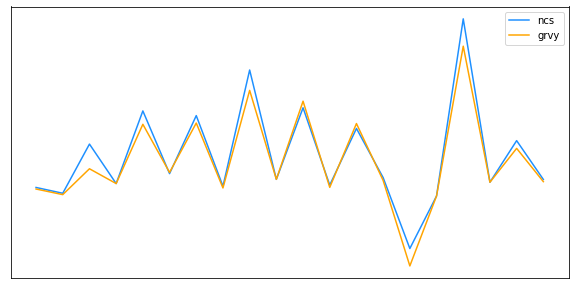

In [162]:
plt.figure(figsize=(10, 5))
plt.plot(X_rocket[3], c='dodgerblue')
plt.plot(X_rocket[4], c='orange')
plt.xticks([])
plt.yticks([])
plt.legend(company[3:5])
plt.savefig('ncsgrvy2.png',dpi=200)

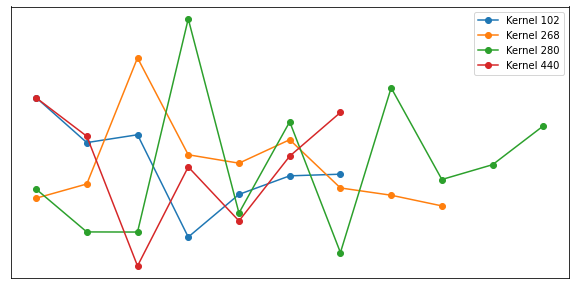

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.datasets import load_gunpoint
from pyts.transformation import ROCKET
from sklearn.feature_selection import mutual_info_classif
import random

# Toy dataset
X, _, y, _ = load_gunpoint(return_X_y=True)

# ROCKET transformation
rocket = ROCKET(n_kernels=500, random_state=42)
X_rocket = rocket.fit_transform(X)

# Find the most discriminative kernels
n_kernels = 4
mutual_info = mutual_info_classif(X_rocket, y, random_state=42)
# indices = np.floor_divide(np.argsort(mutual_info), 2)[-n_kernels:]
a = list(range(500))
random.shuffle(a)
indices = a[:n_kernels]

# Visualize the weights of the most discriminative kernels
plt.figure(figsize=(10, 5))
for idx in indices:
    plt.plot(rocket.weights_[idx, :rocket.length_[idx]], 'o-',
             label='Kernel {}'.format(idx))
plt.legend(loc='best')
plt.xticks([])
plt.yticks([])
plt.savefig('kernels1.png',dpi=200)
plt.show()

# MVP

In [4]:
from tsai.all import *
from tstplus import *
from MVP import *

In [5]:
appened_data = torch.Tensor(processed_data[:,np.newaxis,:])
# splits = get_predefined_splits(appened_data,appened_data)
splits = tuple([L(list(np.arange(0,len(appened_data))))]*2)
batch_tfms = [TSStandardize(by_sample=True)]
tfms = [None, TSClassification()]
x = get_ts_dls(appened_data, splits=splits, batch_tfms=batch_tfms)

In [6]:
learn = ts_learner(x, newTSTPlus, cbs=[my_MVP()], c_out=100)
learn.fit_one_cycle(100, 1e-2)
del learn

epoch,train_loss,valid_loss,time
0,0.973483,1.637361,00:00
1,1.368426,1.079677,00:00
2,1.245608,1.113547,00:00
3,1.210077,1.476856,00:00
4,1.258278,1.011736,00:00
5,1.227821,0.872986,00:00
6,1.170748,1.111326,00:00
7,1.163258,0.969439,00:00
8,1.133991,0.808364,00:00
9,1.106675,1.158150,00:00


/usr/local/lib/python3.8/site-packages/torch/_tensor.py:579: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(other, self)
best epoch:  99  val_loss: 0.758614 - pretrained weights_path='data/MVP/model.pth'


In [7]:
model = torch.load('model/model.pkl')
# model = learn.model
model = model.eval()
for p in model.parameters():
    p.requires_grad=False

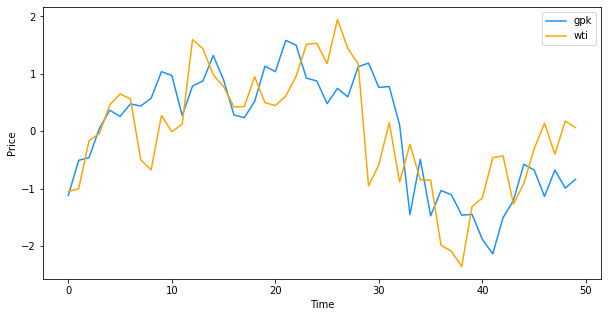

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(processed_data[5], c='dodgerblue')
plt.plot(processed_data[6], c='orange')
plt.legend(company[5:7])
plt.xlabel('Time')
plt.ylabel('Price')
plt.savefig('gpkwti1.png',dpi=200)

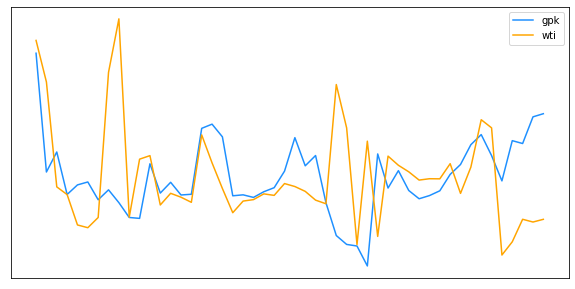

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(o[5], c='dodgerblue')
plt.plot(o[6], c='orange')
plt.xticks([])
plt.yticks([])
plt.legend(company[5:7])
plt.savefig('gpkwti2.png',dpi=200)

# Statisitical features

In [8]:
fts = {'mean': mean, 'std': std, 'skew': skew, 'KURT': kurt}

In [9]:
feature_transfomer = FeatureRep(features=fts)

In [59]:
gap = 5
row,col = raw_data[:,:,1].shape
transered = raw_data[:,:,1] - np.column_stack((np.zeros((row,gap)),raw_data[:,:,1]))[:,:col]

In [60]:
first_order = feature_transfomer.fit_transform(raw_data[:,1])
second_order = feature_transfomer.fit_transform(transered)
statistic_feature_vector = np.column_stack((first_order, second_order))

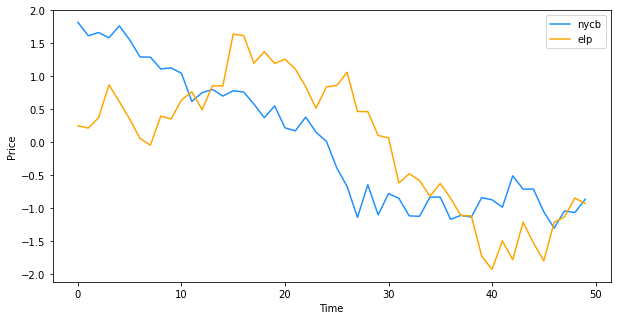

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(processed_data[9], c='dodgerblue')
plt.plot(processed_data[10], c='orange')
plt.legend(company[9:11])
plt.xlabel('Time')
plt.ylabel('Price')
plt.savefig('nycbelp1.png',dpi=200)

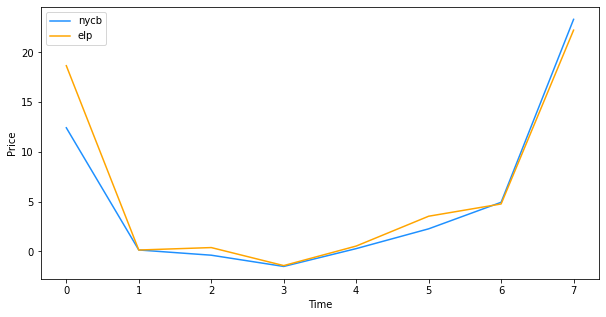

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(statistic_feature_vector[9], c='dodgerblue')
plt.plot(statistic_feature_vector[10], c='orange')
plt.legend(company[9:11])
plt.xlabel('Time')
plt.ylabel('Price')
plt.savefig('nycbelp2.png',dpi=200)

# Path signature

In [99]:
m,n = processed_data.shape

In [123]:
closing_price = processed_data.tolist()
closing_price = np.array([[[k,v] for k,v in enumerate(d)] for d in closing_price])

In [125]:
closing_price.shape

(100, 50, 2)

In [141]:
sig1 = iisignature.sig(closing_price[:,:10],3)

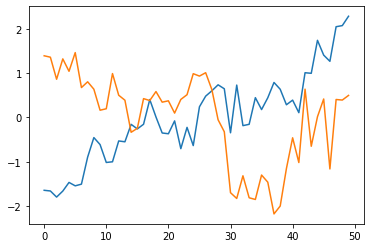

In [165]:
plt.plot(closing_price[1][:,1])
plt.plot(closing_price[2][:,1])

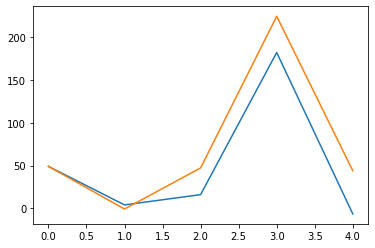

In [166]:
plt.plot(logsig[1])
plt.plot(logsig[2])

In [173]:
s=iisignature.prepare(2,3)
logsig =iisignature.logsig(closing_price,s)

# Clustering

## Prepare data

In [198]:
def display_groups(data, groups, groupNums, figureName=None):
    columns = 4
    rows = math.ceil(groupNums / columns)
    if columns > groupNums:
        columns = groupNums
    figure, ax = plt.subplots(rows, columns, dpi=250, figsize=(columns+1,rows+1))
    counter = 0
    for i in range(groupNums):
        indexes = groups == i
        row = int(counter / columns)
        col = counter % columns
        counter += 1
        if rows == 1:
            cur = ax[col]
        else:
            cur = ax[row,col]
        cur.axis('off')
        cur.set_title('Group {}'.format(i+1))
        for x in data[indexes]:
            cur.plot(x,"k-", alpha=.2)
        barycenter = softdtw_barycenter(data[indexes], gamma=1., max_iter=50, tol=1e-3)
        cur.plot(barycenter.ravel(), "r-", linewidth=2)
    if figureName:
        plt.savefig('{}.png'.format(figureName), dpi=200)
    plt.show()

In [17]:
feature_len = 50

In [27]:
rocket = ROCKET(n_kernels=feature_len//2, random_state=42)
X_rocket = rocket.fit_transform(processed_data)

bop = BagOfPatterns(window_size=8, word_size=4, sparse=False)
X_bop = bop.fit_transform(processed_data)

appened_data = torch.Tensor(processed_data[:,np.newaxis,:])
model = torch.load('model/model.pkl')
model = model.eval()
for p in model.parameters():
    p.requires_grad=False
X_mvp = model(appened_data).numpy().squeeze()

fts = {'mean': mean, 'std': std, 'skew': skew, 'KURT': kurt}
feature_transfomer = FeatureRep(features=fts)
gap = 5
row,col = raw_data[:,:,1].shape
transered = raw_data[:,:,1] - np.column_stack((np.zeros((row,gap)),raw_data[:,:,1]))[:,:col]
first_order = feature_transfomer.fit_transform(raw_data[:,1])
second_order = feature_transfomer.fit_transform(transered)
X_statistic = np.column_stack((first_order, second_order))

closing_price = processed_data.tolist()
closing_price = np.array([[[k,v] for k,v in enumerate(d)] for d in closing_price])
X_sig = iisignature.sig(closing_price,5)

In [31]:
print('Processed data:', processed_data.shape)
print('ROCET:', X_rocket.shape)
print('BOP:', X_bop.shape)
print('MVP:', X_mvp.shape)
print("Statistic:", X_statistic.shape)
print("Signature:", X_sig.shape)

Processed data: (100, 50)
ROCET: (100, 50)
BOP: (100, 136)
MVP: (100, 50)
Statistic: (100, 8)
Signature: (100, 62)


In [4]:
X = processed_data

In [40]:
round_each_clustering = 5
Ks = list(range(5, 30))
all_scores = {}
all_preds = {}
all_inits = {}
features_name = ['Raw','Rocket','BOP','MVP','Feature','Signature']
features_set = [processed_data, X_rocket,X_bop,X_mvp, X_statistic, X_sig]
for name, X in zip(features_name, features_set):
    biggest = np.max(X)
    smallest = np.min(X)
    f_ratios = []
    SCs = []
    CHs = []
    DBIs = []
    preds = []
    inits = []
    shape = X.shape
    for k in Ks:
        least = float('inf')
        best_init = None
        best_pred = None
        best_f_ratio = None
        best_sc = None
        best_ch = None
        best_db = None
        for i in range(round_each_clustering):
            init = np.random.randint(smallest, biggest, size=(k, shape[-1]))
            pred = cluster.KMeans(n_clusters=k, init=init, n_init=1).fit_predict(X)
            # f_ratio = f_ratio_euclidean(processed_data, pred)
            sc = silhouette_score(processed_data, pred, metric='euclidean')
            ch = calinski_harabasz_score(processed_data, pred)
            db = davies_bouldin_score(processed_data, pred)
            # score = sc + ch - f_ratio - db
            score = sc + ch - db
            if score < least:
                least = score

                # best_f_ratio = f_ratio
                best_sc = sc
                best_ch = ch
                best_db = db

                best_init = init
                best_pred = pred
        # f_ratios.append(best_f_ratio)
        SCs.append(best_sc)
        CHs.append(best_ch)
        DBIs.append(best_db)

        inits.append(best_init)
        preds.append(best_pred)
    all_scores[name] = {}
    # all_scores[name]['f_ratios'] = f_ratios
    all_scores[name]['SCs'] = SCs
    all_scores[name]['CHs'] = CHs
    all_scores[name]['DBIs'] = DBIs
    all_preds[name] = preds
    all_inits[name] = inits
    # plt.figure(figsize=(7,7))
    # plt.plot(Ks, scores)
    # plt.xlabel("K")
    # plt.ylabel("F-ratio")
    # plt.title("F-ratio index versus K")
    # plt.show()

In [106]:
processed_data = pre_process_data(datas, compression='pip')

In [107]:
processed_data.shape

(100, 50)

# PIP PAA Downsample测试

In [184]:
round_each_clustering = 3
Ks = list(range(2, 16))
all_scores = {}
all_preds = {}
all_inits = {}
pip_x = pre_process_data(datas, compression='pip')
paa_x = pre_process_data(datas, compression='paa')
down_x = pre_process_data(datas, compression='downsample')
features_name = ['PIP','PAA','Downsample']
features_set = [pip_x,paa_x,down_x]
for name, X in zip(features_name, features_set):
    biggest = np.max(X)
    smallest = np.min(X)
    f_ratios = []
    SCs = []
    CHs = []
    DBIs = []
    preds = []
    shape = X.shape
    for k in Ks:
        largest = float('-inf')
        best_pred = None
        best_f_ratio = None
        best_sc = None
        best_ch = None
        best_db = None
        for i in range(round_each_clustering):
            pred = KShape(n_clusters=k).fit_predict(X)
            f_ratio = f_ratio_euclidean(processed_data, pred)
            sc = silhouette_score(processed_data, pred, metric='euclidean')
            ch = calinski_harabasz_score(processed_data, pred)
            db = davies_bouldin_score(processed_data, pred)
            # score = sc + ch - f_ratio - db
            score = sc + ch - db
            if score > largest:
                least = score

                # best_f_ratio = f_ratio
                best_sc = sc
                best_ch = ch
                best_db = db

                best_pred = pred
        # f_ratios.append(best_f_ratio)
        SCs.append(best_sc)
        CHs.append(best_ch)
        DBIs.append(best_db)

        preds.append(best_pred)
    all_scores[name] = {}
    # all_scores[name]['f_ratios'] = f_ratios
    all_scores[name]['SCs'] = SCs
    all_scores[name]['CHs'] = CHs
    all_scores[name]['DBIs'] = DBIs
    all_preds[name] = preds

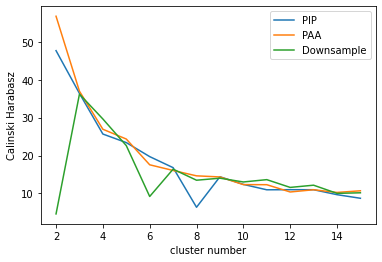

In [185]:
for k,v in all_scores.items():
    plt.plot(Ks, v['CHs'],label=k)
plt.legend()
plt.xlabel('cluster number')
plt.ylabel('Calinski Harabasz')
plt.savefig('kshape_CH1.png', dpi=200)

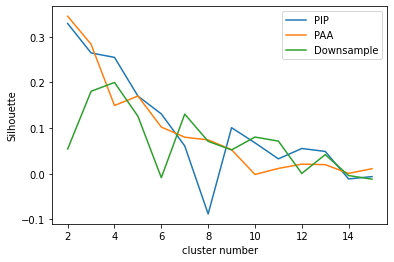

In [186]:
for k,v in all_scores.items():
    plt.plot(Ks, v['SCs'],label=k)
plt.legend()
plt.xlabel('cluster number')
plt.ylabel('Silhouette')
plt.savefig('kshape_silhouette1.png', dpi=200)

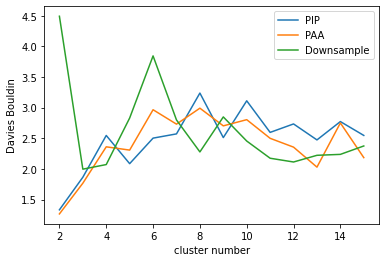

In [187]:
for k,v in all_scores.items():
    plt.plot(Ks, v['DBIs'],label=k)
plt.legend()
plt.xlabel('cluster number')
plt.ylabel('Davies Bouldin')
plt.savefig('kshape_DB1.png', dpi=200)

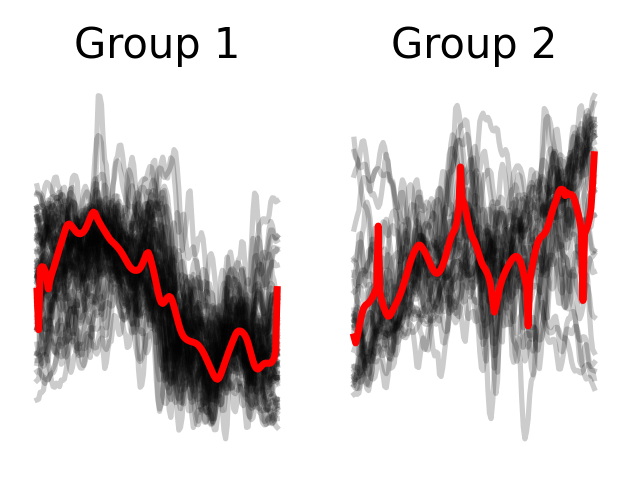

In [199]:
gropu_id = 2
display_groups(processed_data, all_preds['PIP'][gropu_id-Ks[0]], gropu_id, 'KshapePIP1')

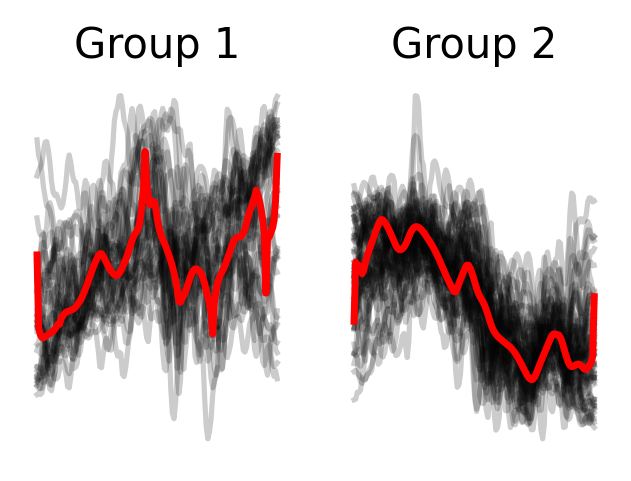

In [200]:
display_groups(processed_data, all_preds['PAA'][gropu_id-Ks[0]], gropu_id,'KshapePAA1')

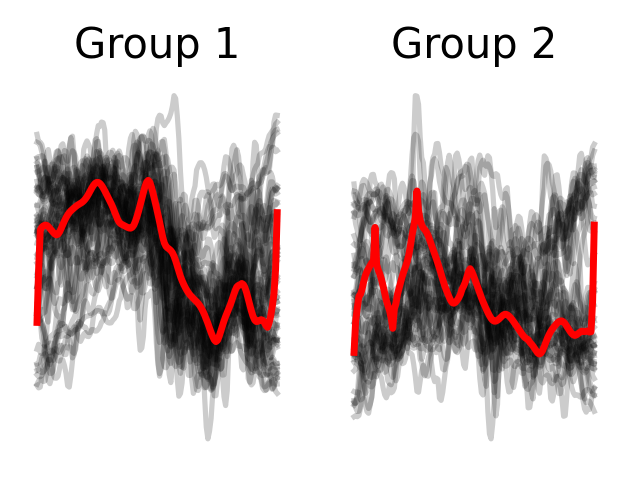

In [201]:
display_groups(processed_data, all_preds['Downsample'][gropu_id-Ks[0]], gropu_id, 'KShapedown1')

In [2]:
50 / 189

0.26455026455026454

In [1]:
"Stock Market Clustering: \\ An Extensive Study on Unsupervised Time-Series Representations".upper()

'STOCK MARKET CLUSTERING: \\ AN EXTENSIVE STUDY ON UNSUPERVISED TIME-SERIES REPRESENTATIONS'